## Algorithm Design

### CNN

In [103]:
# This architectural CNN is from the mind of Deep Mind.
def cnn_model():
    # This model building approach uses the Keras Functional API.
    # The Keras Functional API can be found at: https://keras.io/guides/functional_api/
    image_framework = layers.Input(ATARI_IMAGE_SHAPE, name='image-shape-framework')
    # Normalize 0-255 image scale to within the constraints of 0 and 1.
    # This is done last minute because it is a heavy load to store normalized images, but they
    # can more easily be transformed into processing by the model.
    normalized_images = layers.Lambda(lambda x: x / 255.0, name='normalize-images')(image_framework)

    layer_one_hidden = layers.convolutional.Conv2D(
        LAYER_1_SIZE, LAYER_1_FILTER, strides=LAYER_1_STRIDES, activation=ACTIVATION_FUNCTION
    )(normalized_images)
    layer_two_hidden = layers.convolutional.Conv2D(
        LAYER_2_SIZE, LAYER_2_FILTER, strides=LAYER_2_STRIDES, activation=ACTIVATION_FUNCTION
    )(layer_one_hidden)
    # Flatten before connecting to move to 1D structure.
    flat_layer = layers.core.Flatten()(layer_two_hidden)
    # Dense layer, fully connected.
    fully_connected_layer = layers.Dense(256, activation=ACTIVATION_FUNCTION)(flat_layer)
    # Dense layer is fully connected.
    action_layers = layers.Dense(ACTION_OPTION_COUNT)(fully_connected_layer)
    # Action mask encodes.
    action_input = layers.Input((ACTION_OPTION_COUNT,), name='action-mask')
    # Multiply layer for each action using the encoded action mask.
    mult_res_layer = layers.Multiply(name='deep-q-cnn')([action_layers, action_input])

    model = Model(inputs=[image_framework, action_input], outputs=mult_res_layer)
    model.summary()
    # RMSProp is commonly used for minibatch learning.
    # rho adjusts the influence of the past gradient
    optimizer = RMSprop(lr=LEARNING_RATE, rho=RHO, epsilon=REGULATION_SCALE)
    model.compile(optimizer, loss=huber_loss)
    return model

### Initialization Methods

In [104]:
def get_log_dir():
    curr_time = datetime.utcnow().strftime("%Y%m%d%H%M%S")
    record_dir = TRAIN_DIR + "/openai-atari-{}-logger".format(curr_time)

def init_file_writer_to_local_dir():
    return tf.summary.FileWriter(get_log_dir(), tf.get_default_graph())

def init_batch_matrix():
    return np.zeros((BATCH_SIZE, ATARI_IMAGE_SHAPE[0], ATARI_IMAGE_SHAPE[1], ATARI_IMAGE_SHAPE[2]))

def preprocess(observe):
    grayscale_imgs = rgb2gray(observe)
    shrunk_imgs = resize(grayscale_imgs, ATARI_IMAGE_SHAPE[:2], mode='constant')
    processed_observe = np.uint8(shrunk_imgs * 255)
    return processed_observe

def init_history(observe):
    # At start of game, there is no preceding frame.
    # So just copy initial states to make a starting state.
    state = preprocess(observe)
    history = np.stack((state, state, state, state), axis=2)
    history = np.reshape([history], ATARI_IMAGE_DIMS_B)
    return history

def init_test_config(selected_env):
    env = gym.make(selected_env)
    player_games = 0
    episode_number = 0
    epsilon = 0.001
    global_step = NUM_OBSERVABLE_STEPS + 1
    model = load_model(LOGS_FILE_PATH, custom_objects={'huber_loss': huber_loss})
    return (env, player_games, episode_number, epsilon, global_step, model)

def init_model_clone(model):
    # Copy model since actual model weights will get updated later TODO.  when?
    # Clone model using keras api function.
    model_clone = clone_model(model)
    # Clone model weights to new model separately
    model_clone.set_weights(model.get_weights())
    return model_clone

def init_config(selected_env):
    env = gym.make(selected_env)
    # Deque is imported from collections.  Set to a finite size.  New memory will overwrite old.
    memory = deque(maxlen=MAX_MEMORY_SIZE)
    # init
    epsilon = 1.0
    total_steps = 0
    # Init at 0.
    player_game = 0
    return (env, memory, epsilon, total_steps, player_game)

def init_game_config():
    done = False
    dead = False
    game_step = 0
    game_score = 0
    game_lives = 5
    game_loss = 0.0
    return (done, dead, game_step, game_score, game_lives, game_loss)


### Helper Methods

In [105]:
# Action is random if it is an observed state or if by chance based on the epsilon threshold, it is.
# If action is not random it gets generated from the current model based on history data to this point.
# I select the best action from this result.
def get_action(history, epsilon, model, is_in_observed_state):
    # If is_in_observed_state go with random action, otherwise predict it from the model.
    is_below_epsilon_threshole = np.random.rand() <= epsilon
    if is_below_epsilon_threshole or is_in_observed_state:
        return random.randrange(0, ACTION_OPTION_COUNT)
    else:
        q_value = model.predict([history, np.ones(ACTION_OPTION_COUNT).reshape(1, ACTION_OPTION_COUNT)])
    # Offset for 0 indexing of the encoding array location of value
    return np.argmax(q_value[0]) + 1

def update_epsilon(total_steps, epsilon):
    training = (total_steps > NUM_OBSERVABLE_STEPS)
    epsilon_declining = epsilon > EPSILON_MIN
    if epsilon_declining and training:
        epsilon -= EPSILON_DECAY
    return epsilon

def find_state_and_history(observed_state, history):
    next_state = preprocess(observed_state)
    next_state = np.reshape([next_state], ATARI_IMAGE_DIMS_A)
    next_history = np.append(next_state, history)
    return (next_state, next_history)

def find_state_and_history_two(observe, history):
    next_state = preprocess(observe)
    next_state = np.reshape([next_state], ATARI_IMAGE_DIMS_A)
    next_history = np.append(next_state, history[:, :, :, :ACTION_OPTION_COUNT], axis=ACTION_OPTION_COUNT)
    return (next_state, next_history)

def update_game_lifecycle(game_lives, info):
    # Check if the game is over if the agent lost their lives.
    game_dead = game_lives > info['ale.lives']
    # Update game_lives state to match with what the env. knows.
    game_lives = info['ale.lives']
    return (game_dead, game_lives)

def breakout_from_memory(memory):
    training_batch = random.sample(memory, BATCH_SIZE)
    history = init_batch_matrix()
    next_history = init_batch_matrix()
    action, reward, dead = [], [], []

    # Memory is stored in: indices 0 = history, 1 = action, 2 = reward, 3 = next_history, 4 = dead
    # Index constants:
    history_mem_idx = 0
    action_mem_idx = 1
    reward_mem_idx = 2
    next_hist_mem_idx = 3
    dead_mem_idx = 4
    
    # Reorganize 2D array into category sets by column.
    for index, val in enumerate(training_batch):
        history[index] = val[history_mem_idx]
        next_history[index] = val[next_hist_mem_idx]
        action.append(val[action_mem_idx])
        reward.append(val[reward_mem_idx])
        dead.append(val[dead_mem_idx])
        
    return (history, next_history, action, reward, dead)

def get_one_hot_encoding(targets, nb_classes):
    # clip targets to range within 0 and 2 to make sure they are within action possibilities.
    targets = np.clip(targets, 0, 2)
    # array for hot mapping each action
    # classes: 3, targets range from 0 to 2.  
    # The reshape -1 signifies that data is massaged into a dimension that is unknown.
    return np.eye(nb_classes)[np.array(targets).reshape(-1)]

# Huber Loss has a standard formula to maximize loss given complexities in loss variance 
# depending on the size of an image.
# Calculated by using MSE and MAE
def huber_loss(a, b):
    error = K.abs(a - b)
    quadratic_term = K.clip(error, 0.0, 1.0)
    linear_term = error - quadratic_term
    loss = K.mean(0.5 * K.square(quadratic_term) + linear_term)
    return loss


### Debugging Method
It is not necessary to run this but the training is so long it is useful to check in on how it is performing.
Some iterative logging function should be run in case the model quits while the programmer is sleeping or something.

In [106]:
def maybe_log_stuff(model, total_steps, player_game, score, loss, step, memory, file_writer, selected_env, total_score, score_interval_count):
    # debug.
    if player_game % LOG_FREQUENCY == 0:
        avg_score = total_score/score_interval_count
        print("game: {}, total steps: {}, score: {}, avg_score: {}".format(player_game, total_steps, score, avg_score))
        
    # Record model state iteratively since run time is long.    
    if player_game % 1000 == 0 or (player_game + 1) == NUM_TURNS:
        now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
        file_name = "at-{}-time-{}.h5".format(now, selected_env)
        model_path = os.path.join(TRAIN_DIR, file_name)
        model.save(model_path)

    # Update File for storing keras stats.
    loss_summary = tf.Summary(
        value=[tf.Summary.Value(tag="loss", simple_value=loss / float(step))])
    file_writer.add_summary(loss_summary, global_step=player_game)

    score_summary = tf.Summary(
        value=[tf.Summary.Value(tag="score", simple_value=score)])
    file_writer.add_summary(score_summary, global_step=player_game)


### Deep Q-Network Methods

In [107]:
def find_future_rewards_from_q(dead, reward, next_q_values):
    # like Q Learning, get maximum Q value at s'
    # But from target model
    for i in range(BATCH_SIZE):
        if dead[i]:
            # If the agent died there is no future reward predicted
            q_s_a[i] = reward[i]
        else:
            # Q(s, a) = r + gamma * max(Q(s', a')).  Bellman's equation for Q value.
            # train model for future reward.
            q_s_a[i] = reward[i] + GAMMA * np.amax(next_q_values[i])
    # Return future rewards for each action for each state in memory.
    return q_s_a

def train_memory_batch(memory, model, log_dir):
    q_s_a = np.zeros((BATCH_SIZE,))
    # Reorganize from step to categorical.
    history, next_history, action, reward, dead = breakout_from_memory(memory)
    # Hot Encode each action as on.
    actions_mask = np.ones((BATCH_SIZE, ACTION_OPTION_COUNT))
    # Predict for each action with a mask to encode each action.
    next_q_values = model.predict([next_history, actions_mask])
    # [q1, q2, q3]
     # like Q Learning, get maximum Q value at s'
    # But from target model
    for i in range(BATCH_SIZE):
        if dead[i]:
            # If the agent died there is no future reward predicted
            q_s_a[i] = reward[i]
        else:
            # Q(s, a) = r + gamma * max(Q(s', a')).  Bellman's equation for Q value.
            # train model for future reward.
            q_s_a[i] = reward[i] + GAMMA * np.amax(next_q_values[i])

    # Use Bellmans to find future rewards for each memory state, for eac action.
    # (indexing stays constant)

    # Get an action for each possible reward. (np.eye gives diagonal of 1s for action possibilities.)
    # [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
    action_one_hot_enc = get_one_hot_encoding(action, ACTION_OPTION_COUNT)
    # Action mask on reward array.  Get encoding for each reward for each action.
    # this will be the encoding of each action with an updated Q(s, a)
    # [[1, 0, 0], [0, 1, 0], [0, 0, 1]] * [q1, q2, q3]
    rewards_one_hot_enc = action_one_hot_enc * q_s_a[:, None]
    
    # Training data is on [history, action_one_hot], classifier is rewards.
    # Maps *(states, actions)* to --> *rewards for each possible action*.  
    # Rewards are hot encoded.
    # When predicting, the highest reward will be pulled from the one hot encoded action array.
    h = model.fit(
        [history, action_one_hot_enc], rewards_one_hot_enc, epochs=1,
        batch_size=BATCH_SIZE, verbose=0)

    return h.history['loss'][0]

# This function parents the deep Q Network if the model has enough memory for batch training.
def deep_q_iteration_training(memory, total_steps, model_clone, model):
    log_dir = None
    loss = train_memory_batch(memory, model, log_dir)
    if total_steps % MODEL_WEIGHTS_REFRESH_THRESOLD == 0:
        # Weights on the model clone get piped through so they only get updated as often as 
        # the treshold dictates the cycle update them.
        model_clone.set_weights(model.get_weights())
    return (model_clone, loss)

### Training Method

In [120]:
# # Mostly this function keeps track of system states, memory, and flags
# # It provides the opportunity to create logs for debugging
# # Most importantly it takes an action and updates a score.
# # It runs training on the model if all observation has been done.  This is Deep Q Learning.
def train(selected_env):
    # Initialize global states.
    env, memory, epsilon, total_steps, player_games = init_config(selected_env)
    # Initialize storage for collecting data on model performance.
    total_score = 0
    score_interval_count = 0
    avg_game_scores = []
    # Get a copy of the cnn model with the architecture defined in a separate function.
    model = cnn_model()
    # Initialize file writer for logging. 
    
    # Initialize file writer.  
    # Used for logging and storing the model iteratively to preserve work.
    file_writer = init_file_writer_to_local_dir()
    
    # The main model gets used in the Q learning training, and based on updated weights, 
    # then also updates the model clone.  
    # Targeted Network update.
    model_clone = init_model_clone(model)
    
    # A loop to cover the range of the global number of games played.
    # The player games number is kept visible to the program for logging purposes.
    while player_games < NUM_TURNS:
        # Define global game states.
        game_done, player_dead, game_step, game_score, game_lives, game_loss = init_game_config()
        # Reset the environment at the beginning of each game.
        observe = env.reset()

        # Prefill the start state, 4 frames create a state.
        for _ in range(random.randint(1, INIT_NO_OP_STEPS)):
            observe, _, _, _ = env.step(1)
        history = init_history(observe)

        # Have the agent play a game given their turn.
        while not game_done:
            is_in_observed_state = (total_steps <= NUM_OBSERVABLE_STEPS)
            is_in_training_state = not is_in_observed_state
            
            # Epsilon has to decay a tiny bit with each iteration in the annealing method.
            epsilon = update_epsilon(total_steps, epsilon)

            # Get an action
            action = get_action(history, epsilon, model_clone, is_in_observed_state)

            # Take a step in the game
            observed_state, reward, game_done, info = env.step(action)
            
            # Update score based on agent action.
            # Move reward to the poles of 1 or -1.
            game_reward = np.clip(reward, -1., 1.)
            game_score += game_reward
            
            # Preprocess state data and merge it with history.
            next_state = preprocess(observe)
            next_state = np.reshape([next_state], ATARI_IMAGE_DIMS_A)
            next_history = np.append(next_state, history[:, :, :, :ACTION_OPTION_COUNT], axis=ACTION_OPTION_COUNT)
            
            # Get info from env. info on agent status and their current life in the game.
            player_dead, game_lives = update_game_lifecycle(game_lives, info)
            
            # Update memory.
            memory.append((history, action, reward, next_history, player_dead))
            
            # Deep Q learning begins if the observational state is complete.
            # When the model has sufficiently recorded enough memory for training, start batch training.
            if is_in_training_state:
                model_clone, model_loss = deep_q_iteration_training(memory, total_steps, model_clone, model)
                game_loss += model_loss
                
            if not player_dead:
                # Update history to include the state if the agent didn't die.
                history = next_history
            
            # Update counts and state flags.
            player_dead = False
            # These are used more of less for logging and aren't too important to the system.
            total_steps += 1
            game_step += 1
            
            if game_done:
                total_score += game_score
                score_interval_count += 1
                maybe_log_stuff(model, total_steps, player_games, game_score, game_loss, game_step, memory, file_writer, selected_env, total_score, score_interval_count)
                player_games += 1
                # Update the total game score for the metric logs that the function returns.
                
                # Take a log sample and reset game score counter for the interval.
                if player_games % SAMPLE_SCORE_INTERVAL == 0:
                    avg_game_score = total_score/SAMPLE_SCORE_INTERVAL
                    avg_game_scores.append(avg_game_score)
                    print('avg: ', avg_game_scores)
                    total_score = 0
                    score_interval_count = 0
    file_writer.close()
    return avg_game_scores


### Test Method

In [121]:
def test(selected_env, log_file_path):
    env = gym.make(selected_env)
    player_games = 0
    epsilon = 0.001
    global_step = NUM_OBSERVABLE_STEPS + 1
    model = load_model(log_file_path, custom_objects={'huber_loss': huber_loss})
    total_score = 0
    avg_game_scores = []

    while player_games < NUM_TURNS:
        # init variables
        done, player_dead, game_step, game_score, game_lives, game_loss = init_game_config()
        
        observe = env.reset()

        # Copy in initial states to amount to initial four frame history
        observe, _, _, _ = env.step(1)
        history = init_history(observe)

        while not done:
            if RENDER is True:
                env.render()
                time.sleep(0.01)

            is_in_observed_state = (global_step <= NUM_OBSERVABLE_STEPS)
            # get action for the current history and go one step in environment
            action = get_action(history, epsilon, model, is_in_observed_state)

            observe, reward, done, info = env.step(action)
            # pre-process the observation --> history
            next_state, next_history = find_state_and_history_two(observe, history)

            game_dead, game_lives = update_game_lifecycle(game_lives, info)

            # move reward to the poles of 1 or -1 per the deep mind paper's suggestion
            game_reward = np.clip(reward, -1., 1.)

            game_score += game_reward

            if not game_dead:
                # Update history to include the state if the agent didn't die.
                history = next_history

            # Update counts and state flags.
            dead = False
            
            if done:
                player_games += 1
                # update average game score log
                total_score += game_score
                # take sample
                if (player_games % SAMPLE_SCORE_INTERVAL) == 0:
                    avg_game_score = total_score/SAMPLE_SCORE_INTERVAL
                    avg_game_scores.append(avg_game_score)
                    print('avg: ', avg_game_scores)
                    total_score = 0
                print('avg scores array: ', avg_game_scores)
    return avg_game_scores


## Implementation

### Imports

In [122]:
%%capture
import gym
import random
import numpy as np
import tensorflow as tf

from keras import layers
from keras.models import Model

from collections import deque
from keras.optimizers import RMSprop
from keras import backend as K
from skimage.color import rgb2gray
from skimage.transform import resize
from datetime import datetime
import os.path
import time
from keras.models import load_model
from keras.models import clone_model
from keras.callbacks import TensorBoard

import matplotlib.pyplot as plt
from scipy.interpolate import spline

### Constants

In [123]:
TRAIN_DIR = 'openai_breakout_training_storage'
LOGS_FILE_PATH_BREAKOUT = '/Users/catherinejohnson/projects/CSCI_3202/deepQNetwork/openai_breakout_training_storage/breakout_model_20201128034415.h5'
LOGS_FILE_PATH_SPACE_I = '/Users/catherinejohnson/projects/CSCI_3202/deepQNetwork/openai_breakout_training_storage/training_20201129043723.h5'
# suggested by Deep Mind Paper
ATARI_IMAGE_SHAPE = (84, 84, 4)
ATARI_IMAGE_DIMS_A = (1, 84, 84, 1)
ATARI_IMAGE_DIMS_B = (1, 84, 84, 4)
ATARI_IMAGE_SHAPE = (84, 84, 4)
ACTION_OPTION_COUNT = 3
RENDER = True
# Other Constants
MAX_MEMORY_SIZE = 400000
EPSILON_MIN = 0.1
EPSILON_DECAY = ((1.0 - EPSILON_MIN) / 1000000)
ATARI_BREAKOUT_ENV_NAME = 'BreakoutDeterministic-v4'
ATARI_SPACE_ENVADERS_ENV_NAME = 'SpaceInvadersDeterministic-v4'
ATARI_SKIING_ENV_NAME = 'SkiingDeterministic-v4'
ATARI_TENNIS_ENV_NAME = 'TennisDeterministic-v4'
REGULATION_SCALE = 0.01
RHO = 0.95

# Constants suggested by Deep Mind Paper
LAYER_1_SIZE = 16
LAYER_1_FILTER = (8, 8)
LAYER_1_STRIDES = (4, 4)
LAYER_2_SIZE = 32
LAYER_2_FILTER = (4, 4)
LAYER_2_STRIDES = (2, 2)
ACTIVATION_FUNCTION = 'relu'
NUM_TURNS = 100000
NUM_OBSERVABLE_STEPS = 50000
MODEL_WEIGHTS_REFRESH_THRESOLD = 10000
INIT_NO_OP_STEPS = 30
BATCH_SIZE = 32
LEARNING_RATE = 0.00025
GAMMA = 0.99
EPSILON_DECAY = ((1.0 - EPSILON_MIN) / NUM_TURNS)

# Overrides to Deep Mind Suggestions
NUM_TURNS = 500
NUM_OBSERVABLE_STEPS = 100
MODEL_WEIGHTS_REFRESH_THRESOLD = 50
INIT_NO_OP_STEPS = 30
BATCH_SIZE = 32
# This needs to be low enough things get logged!
SAMPLE_SCORE_INTERVAL = 10
LOG_FREQUENCY = 5


# Refresh this with new number of turns constant.
EPSILON_DECAY = ((1.0 - EPSILON_MIN) / NUM_TURNS)

# Overrides for Network Constants
NETWORK_UPDATE_CONSTANT = 2

# Increased the number of nodes, filter size, and strides by a constant for the network.
LAYER_1_SIZE = LAYER_1_SIZE * NETWORK_UPDATE_CONSTANT
LAYER_1_FILTER = (LAYER_1_FILTER[0] * NETWORK_UPDATE_CONSTANT, LAYER_1_FILTER[1] * NETWORK_UPDATE_CONSTANT)
LAYER_1_STRIDES = (LAYER_1_STRIDES[0] * NETWORK_UPDATE_CONSTANT, LAYER_1_STRIDES[1] * NETWORK_UPDATE_CONSTANT)
LAYER_2_SIZE = LAYER_2_SIZE * NETWORK_UPDATE_CONSTANT
LAYER_2_FILTER = (LAYER_2_FILTER[0] * NETWORK_UPDATE_CONSTANT, LAYER_2_FILTER[1] * NETWORK_UPDATE_CONSTANT)
LAYER_2_STRIDES = (LAYER_2_STRIDES[0] * NETWORK_UPDATE_CONSTANT, LAYER_2_STRIDES[1] * NETWORK_UPDATE_CONSTANT)
# Increased the learning rate to speed it up.
LEARNING_RATE = 0.1


In [118]:
avg_game_scores_breakout_training = train(ATARI_BREAKOUT_ENV_NAME)

Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image-shape-framework (InputLay (None, 84, 84, 4)    0                                            
__________________________________________________________________________________________________
normalize-images (Lambda)       (None, 84, 84, 4)    0           image-shape-framework[0][0]      
__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, 9, 9, 32)     32800       normalize-images[0][0]           
__________________________________________________________________________________________________
conv2d_31 (Conv2D)              (None, 1, 1, 64)     131136      conv2d_30[0][0]                  
___________________________________________________________________________________________

In [ ]:
LAYER_1_SIZE

In [124]:
avg_game_scores_spaci_training = train(ATARI_SPACE_ENVADERS_ENV_NAME)

Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image-shape-framework (InputLay (None, 84, 84, 4)    0                                            
__________________________________________________________________________________________________
normalize-images (Lambda)       (None, 84, 84, 4)    0           image-shape-framework[0][0]      
__________________________________________________________________________________________________
conv2d_32 (Conv2D)              (None, 9, 9, 32)     32800       normalize-images[0][0]           
__________________________________________________________________________________________________
conv2d_33 (Conv2D)              (None, 1, 1, 64)     131136      conv2d_32[0][0]                  
___________________________________________________________________________________________

In [ ]:
# manually update file in RESTORE_FILE_PATH for testing.
avg_game_scores_breakout_testing = test(ATARI_BREAKOUT_ENV_NAME, LOGS_FILE_PATH_BREAKOUT)

In [ ]:
avg_game_scores_spaci_testing = test(ATARI_SPACE_ENVADERS_ENV_NAME, LOGS_FILE_PATH_SPACE_I)

In [177]:
print('s i first 10 avg scores: ', avg_game_scores_spaci_training[:9])
print('b r first 10 avg scores: ', avg_game_scores_breakout_training[:9])

s i first 10 avg scores:  [7.6, 8.2, 8.2, 9.2, 10.8, 6.4, 15.2, 15.2, 9.2]
b r first 10 avg scores:  [0.8, 2.0, 1.4, 2.0, 1.8, 1.6, 2.4, 1.0, 2.4]


[0.8, 2.0, 1.4, 2.0, 1.8, 1.6, 2.4, 1.0, 2.4, 1.2]


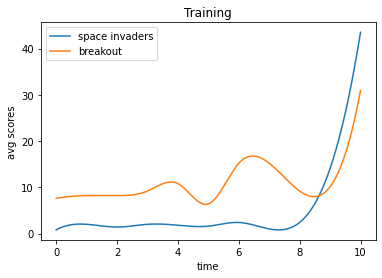

In [180]:
from scipy.interpolate import make_interp_spline

x_len = len(avg_game_scores_breakout_training)
time_series = [i for i in range(0, x_len)]
x_len_minus = x_len-1

x = np.array(time_series[:x_len_minus])
y_b = np.array(avg_game_scores_breakout_training[:x_len_minus])
y_s = np.array(avg_game_scores_spaci_training[:x_len_minus])
x_new = np.linspace(0, len(time_series), 10000)

a_BSpline_b = make_interp_spline(x, y_b)
a_BSpline_s = make_interp_spline(x, y_s)

y_new_b = a_BSpline_b(x_new)
y_new_s = a_BSpline_s(x_new)

plt.plot(x_new, y_new_b)
plt.plot(x_new, y_new_s)

print(avg_game_scores_breakout_training)
#plt.plot(time_series)
plt.title('Training')
plt.ylabel('avg scores')
plt.xlabel('time')
plt.legend(['space invaders', 'breakout'], loc='upper left')
plt.show()

In [ ]:
print(avg_game_scores_breakout_testing)

In [ ]:
plt.plot(avg_game_scores_breakout_testing)
plt.plot(avg_game_scores_spaci_testing)
print(avg_game_scores_breakout_testing)
plt.title('Testing')
plt.ylabel('avg scores')
plt.xlabel('time')
plt.legend(['space invaders', 'breakout'], loc='upper left')
plt.show()